Init

In [63]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import sklearn.preprocessing

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold

### Pucydane

In [64]:
df = pd.read_csv('data/DIAMOND_eun1_SOLOQ_cleared.csv')

In [65]:
df.rename(columns={'1_result': '1_win'})
df.iloc[:,1] = df.iloc[:,1] == "Win"
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns = df.columns)

In [66]:
X = df.iloc[:,2:]
y = df.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [67]:
model = LogisticRegression()

In [68]:
model.fit(X_train, y_train)

LogisticRegression()

In [69]:
predictions = model.predict(X_test)

In [70]:
accuracy_score(y_test, predictions)

0.7124117053481333

In [71]:
results = {
    'XGBoost bez skalowania': 0.677598385469223,
    'XGBoost ze skalowaniem': 0.6770938446014128,
    'LogisticRegression bez skalowania': 0.6937436932391524,
    'LogisticRegression z skalowania': 0.7124117053481333,
    'SVC bez skalowania': 0.6927346115035318,
    'SVC ze skalowaniem': 0.7048435923309788,
}

In [72]:
def get_acc(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(accuracy_score(y_test, predictions))

/home/maurykdell/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


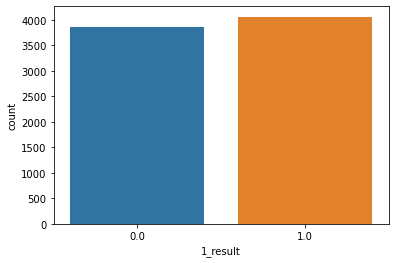

In [73]:
sns.countplot(y_train)
plt.show()

Model stacking

In [74]:
# Initializing CatBoost classifier, fitting and then predicting
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.3, depth=5, loss_function='MultiClass', classes_count=2, logging_level='Silent', l2_leaf_reg=2, thread_count=4)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_preds = cat_preds.reshape((-1,)).astype(int)

In [75]:
# Initializing Random Forest classifier, fitting and then predicting
rfc_clf = RandomForestClassifier(n_estimators=70, max_depth=5, max_features=0.8, n_jobs=4, class_weight='balanced')
rfc_clf.fit(X_train, y_train)
rfc_preds = rfc_clf.predict(X_test).astype(int)

In [76]:
# Initializing Adam Boost classifier, fitting and then predicting
ada_clf = AdaBoostClassifier(n_estimators=70, learning_rate=0.3)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test).astype(int)

In [77]:
# Initializing Bernoulli naive-bayes classifier, fitting and then predicting
bernoulli_clf = BernoulliNB()
bernoulli_clf.fit(X_train, y_train)
bernoulli_preds = bernoulli_clf.predict(X_test).astype(int)

In [78]:
# Initializing Gaussian naive-bayes classifier, fitting and then predicting
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, y_train)
gaussian_preds = gaussian_clf.predict(X_test).astype(int)

In [79]:
# Initializing KNN classifier, fitting and then predicting
knn_clf = KNeighborsClassifier(n_neighbors=8, weights='uniform', n_jobs=4)
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test).astype(int)

In [80]:
# Initializing Multilayer Perceptron, fitting and then predicting
mlp_clf = MLPClassifier(hidden_layer_sizes=(50), batch_size=50, learning_rate='constant', learning_rate_init=0.0005, early_stopping=True)
mlp_clf.fit(X_train, y_train)
mlp_preds = mlp_clf.predict(X_test).astype(int)

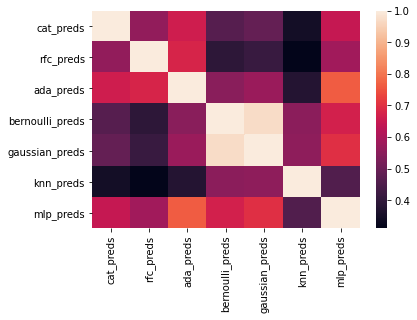

In [81]:
# Combining all predictions and creating a heatplot of their correlations
all_preds = np.concatenate((cat_preds.reshape((-1, 1)), rfc_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, ada_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, bernoulli_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, gaussian_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, knn_preds.reshape((-1, 1))), axis=1)
all_preds = np.concatenate((all_preds, mlp_preds.reshape((-1, 1))), axis=1)

all_preds_df = pd.DataFrame(all_preds, columns=['cat_preds', 'rfc_preds', 'ada_preds', 'bernoulli_preds', 'gaussian_preds', 'knn_preds', 'mlp_preds'])
sns.heatmap(all_preds_df.corr())
plt.show()


/home/maurykdell/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


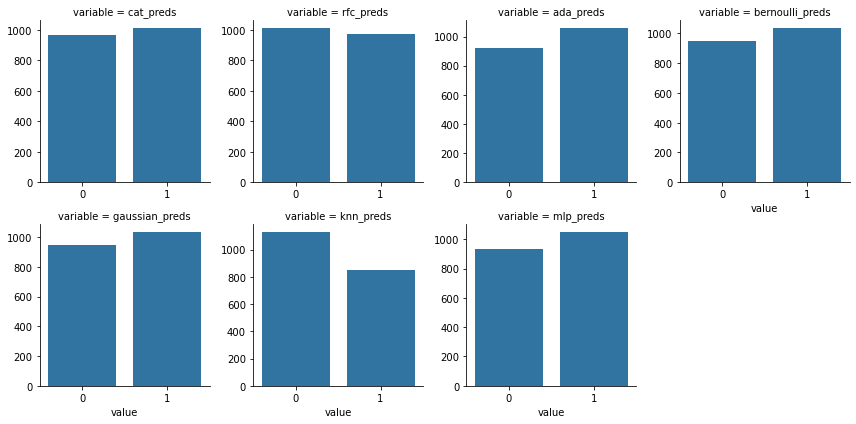

In [82]:
# Visualizing and comparing the freqencies of predicted classes of all models
all_preds_flat = pd.melt(all_preds_df)
g = sns.FacetGrid(all_preds_flat, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')
plt.show()

In [90]:
# Creating level1_train dataset
level1_train = np.zeros((X_train.shape[0], 14))
skf = StratifiedKFold(n_splits=5)

for tr_idx, te_idx in skf.split(X_train, y_train):
    
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_te, y_te = X_train.iloc[te_idx], y_train.iloc[te_idx]
    
    cat_model.fit(X_tr, y_tr)
    cat_preds = cat_model.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7] = cat_preds[:, i]
    
    rfc_clf.fit(X_tr, y_tr)
    rfc_preds = rfc_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+1] = rfc_preds[:, i]
    
    ada_clf.fit(X_tr, y_tr)
    ada_preds = ada_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+2] = ada_preds[:, i]
    
    bernoulli_clf.fit(X_tr, y_tr)
    bernoulli_preds = bernoulli_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+3] = bernoulli_preds[:, i]
    
    gaussian_clf.fit(X_tr, y_tr)
    gaussian_preds = gaussian_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+4] = gaussian_preds[:, i]
    
    knn_clf.fit(X_tr, y_tr)
    knn_preds = knn_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+5] = knn_preds[:, i]

    mlp_clf.fit(X_tr, y_tr)
    mlp_preds = mlp_clf.predict_proba(X_te)
    for i in range(2):
        level1_train[te_idx, i*7+6] = mlp_preds[:, i]



In [91]:
# Creating level1_test dataset
level1_test = np.zeros((X_test.shape[0], 14))

cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7] = cat_preds[:, i]

rfc_clf.fit(X_train, y_train)
rfc_preds = rfc_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+1] = rfc_preds[:, i]

ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+2] = ada_preds[:, i]

bernoulli_clf.fit(X_train, y_train)
bernoulli_preds = bernoulli_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+3] = bernoulli_preds[:, i]
    
gaussian_clf.fit(X_train, y_train)
gaussian_preds = gaussian_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+4] = gaussian_preds[:, i]
    
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+5] = knn_preds[:, i]

mlp_clf.fit(X_train, y_train)
mlp_preds = mlp_clf.predict_proba(X_test)
for i in range(2):
    level1_test[:, i*7+6] = mlp_preds[:, i]

In [100]:
# Training a meta classifier on level1_train dataset and making predictions on level1_test dataset
meta_clf = LogisticRegression()
meta_clf.fit(level1_train, y_train)
meta_preds = meta_clf.predict(level1_test).astype(int)
print(accuracy_score(y_test, meta_preds))

0.7033299697275479


In [ ]:
0.7048435923309788

Czyjś pomysł xD

In [108]:
# X = MinMaxScaler().fit_transform(df.drop(['blueWins', 'gameId'], axis=1))
import lightgbm as lgb
from bayes_opt import BayesianOptimization
def bayes_parameter_opt_lgb(X = X, y = y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'verbose': -1, 'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            #'verbose': (-1),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  1        |  0.7462   |  0.9098   |  0.6722   |  3.014    |  1.635    |  6.69     |  34.07    |  0.04432  |  42.73    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  2        |  0.747    |  0.9927   |  0.4068   |  3.959    |  1.587    |  7.266    |  46.65    |  0.008033 |  25.83    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  3        |  0.7463   |  0.804    |  0.7661   |  3.891    |  2.61     |  8.905    |  40.96    |  0.04669  |  40.39    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  4        |  0.7474   |  0.8237   |  0.6119   |  0.7168   |  2.834    |  7.082    |  23.66    |  0.02719  |  40.26    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  5        |  0.7463   |  0.8912   |  0.5547   |  0.09395  |  1.853    |  7.442    |  32.76    |  0.09443  |  38.32    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  6        |  0.7475   |  0.8011   |  0.3097   |  0.6466   |  2.962    |  6.669    |  18.44    |  0.026    |  39.36    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  7        |  0.7457   |  0.876    |  0.7927   |  4.381    |  1.31     |  8.653    |  18.45    |  0.01395  |  30.27    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  8        |  0.7469   |  0.8334   |  0.8964   |  0.0      |  3.0      |  5.007    |  19.5     |  0.04407  |  45.0     |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  9        |  0.7442   |  1.0      |  0.1      |  0.0      |  0.0      |  8.99     |  20.51    |  0.1      |  40.44    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  10       |  0.748    |  0.9175   |  0.2053   |  0.7007   |  0.203    |  8.891    |  41.4     |  0.06127  |  25.83    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  11       |  0.7459   |  0.9723   |  0.4481   |  1.993    |  1.737    |  7.396    |  22.67    |  0.03566  |  42.06    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  12       |  0.7463   |  0.9172   |  0.8446   |  2.612    |  0.9115   |  8.531    |  13.87    |  0.06858  |  31.82    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  13       |  0.7467   |  0.8104   |  0.5932   |  4.229    |  1.605    |  7.63     |  47.09    |  0.05909  |  25.5     |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  14       |  0.7486   |  0.9221   |  0.327    |  1.368    |  0.8621   |  8.355    |  42.16    |  0.04255  |  25.86    |


/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/maurykdell/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  15       |  0.746    |  1.0      |  0.1466   |  2.989    |  0.07056  |  8.35     |  42.67    |  0.001    |  25.54    |
